#Introduction/Background

Current work has been detailed in GDocs but needs to be 'practialised'.

Intention for this week is to match development to Bella's Chapter 4 Analysis of Trust and a little more, encompassing:
* Demonstration of Trust Assessment from Metrics
* Exploration of Packet Emmission Rate for Standard Static Case
* Exploration of Existing Mobility Models (static, 1-mobile, allbut1-mobile, all-mobile)
* Exploration of Generalised Trust Performance across Varying Distances
* Trust Weighting across the above
* OTMF/Beta comparative Assessment of the above
* Exploration of Time-series smoothing for trust (EWMA/Retrospective Observations, etc)

This notebook should also operate as a 'test suite' 

# Required Modules and Configurations

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import quantities as q
from collections import OrderedDict
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform

import aietes
import aietes.Tools as Tools
import bounos.ChartBuilders as cb
import bounos.Analyses.Trust as Trust
import bounos.multi_loader as multi_loader

#print(matplotlib.rcParams)
_boxplot_kwargs = {
    'showmeans':True,
    'showbox':False,
    'widths':0.2,
    'linewidth':2
}

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

import scipy.interpolate as interpolate
#pylab.rcParams['figure.figsize'] = 16, 12  

golden_mean  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
w=4
cb.latexify(columns=2, factor=0.8)

def interpolate_rate_sep(df, key):
    X,Y,Z = df.rate, df.separation, df[key]

    xi = np.linspace(X.min(),X.max(),16)
    yi = np.linspace(Y.min(),Y.max(),16)
    # VERY IMPORTANT, to tell matplotlib how is your data organized
    zi = interpolate.griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='linear')
    return xi,yi,zi, X, Y
    
def plot_contour_pair(xi,yi,zi):
    fig = plt.figure(figsize=(2*w,golden_mean*w*2))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    

    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    xig, yig = np.meshgrid(xi, yi)

    surf = ax.plot_surface(xig, yig, zi,linewidth=0)
    return fig

def plot_contour_3d(xi,yi,zi, rot=120, labels=None):
    fig = plt.figure(figsize=(w,golden_mean*w))
    ax = fig.add_subplot(1,1,1, projection='3d')
    # Normalise Z
    zi_norm = zi / np.nanmax(zi)
    xig, yig = np.meshgrid(xi, yi)
    
    if rot < 90:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmin(xig)
        yoffset=np.nanmin(yig)
    elif rot < 180:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmax(xig)
        yoffset=np.nanmin(yig)
    else:
        zoffset=np.nanmin(zi)
        xoffset=np.nanmax(xig)
        yoffset=np.nanmax(yig)
    
    ax.plot_surface(xig, yig, zi, rstride=1, cstride=1, alpha=0.45, facecolors=cm.coolwarm(zi_norm), linewidth=1, antialiased=True)
    cset = ax.contour(xig, yig, zi, zdir='z', offset=zoffset, linestyles='dashed', cmap=cm.coolwarm)
    cset = ax.contour(xig, yig, zi, zdir='x', offset=xoffset, cmap=cm.coolwarm)
    cset = ax.contour(xig, yig, zi, zdir='y', offset=yoffset, cmap=cm.coolwarm)
    ax.view_init(30,rot)
    
    if labels is not None:
        ax.set_xlabel(labels['x'])
        ax.set_ylabel(labels['y'])
        ax.set_zlabel(labels['z'])
        
    fig.tight_layout()
    return fig

def plot_contour_2d(xi,yi,zi, X=[],Y=[], var=None, norm=False):
    fig = plt.figure(figsize=(w,golden_mean*w), facecolor='white')
    ax = fig.add_subplot(1,1,1)
    xig, yig = np.meshgrid(xi, yi)
    x_min,y_min=map(np.nanmin,(xi,yi))
    x_max,y_max=map(np.nanmax,(xi,yi))
    ax.set_ylim([y_min,y_max])
    ax.set_xlim([x_min,x_max])
    ax.set_xlabel("Packet Emission Rate (pps)")
    ax.set_ylabel("Average Node Separation (m)")

    
    if norm:
        vmin,vmax = 0.0,1.0
    else:
        vmin=np.nanmin(abs(zi))
        vmax=np.nanmax(abs(zi)) 

    cset = ax.contourf(zi, alpha=0.75, #hatches=['+','x','-', '/', '\\', '//'],
                  cmap=plt.get_cmap('hot_r'),
                  vmin=vmin,vmax=vmax,
                  extent=[x_min, x_max, y_min, y_max]
    )
    cbar = fig.colorbar(cset)
    if var is not None:
        #ax.set_title("{} with varying Packet Emission and Node Separations".format(var))
        cbar.set_label(var)

    if len(X) and len(Y):
        ax.scatter(X,Y, color = 'k', marker = '.')
        
    #ax.clabel(cset,inline=1)
    return fig


os.chdir("/home/bolster/src/thesis/Figures")
    

golden_mean  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
w=5
cb.latexify(columns=2, factor=0.55)

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0.9182250000000001, 0.5674942593198723)

In [2]:
_ = np.seterr(invalid='ignore') # Pandas PITA Nan printing
result_h5s_by_latest=sorted(filter(lambda p: os.path.basename(p).endswith("h5"),map(lambda p: os.path.abspath(os.path.join(Tools._results_dir,p)),os.listdir(Tools._results_dir))),key=lambda f:os.path.getmtime(f))
rate_and_ranges=filter(lambda p: os.path.basename(p).startswith("CommsRateAndRangeTest"), result_h5s_by_latest)
app_rate_from_path = lambda s:float(".".join(s.split('-')[2].split('.')[0:-1]))
app_rates = map(app_rate_from_path,rate_and_ranges)

malicious = "MaliciousBadMouthingPowerControlTrustMedianTests-0.025-3-2015-02-19-23-27-01.h5"
good  = "TrustMedianTests-0.025-3-2015-02-19-23-29-39.h5"

# Scenario Specifications

In [3]:
specs=pd.DataFrame([[5,0.7,0.025,6,100,"DSDV","Various",5,1000000,4096,"CBR",10,np.nan],
              [36000,3,1.5,6,100,"FBR", "Various",1.25,300,9600,"Round Robin",1,np.nan],
              [q.s,q.kilometer**2, q.kilometer,None,q.m,None,None,q.meter/q.sec, q.bit/q.sec,q.bit,None,None,q.bit]],
             index="BG,AB,Units".split(','),columns = "Duration,Area,TX Range,Nodes,Node Separation,Routing Protocol,Mobility,Speed,Data Rate,Packet Size,Data Type,Burst Length,Burst Size".split(','))
specs['Burst Size']=specs['Burst Length']*specs['Data Rate']*specs['Packet Size']

# DataFrame Generation

In [4]:
var = "Average Node Separation (m)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
statsd={}
for store_path in rate_and_ranges:
    with pd.get_store(store_path) as s:
        try:
            stats=s.get('stats')
        except KeyError:
            print store_path
            print s.keys()
            raise
        # Reset Range for packet emission rate
        stats.throughput = stats.throughput/3600.0
        stats.index = stats.index.set_levels([
             np.int32((np.asarray(stats.index.levels[0].astype(np.float64))*100)),  # Var
             stats.index.levels[1].astype(np.int32) # Run
            ]+(stats.index.levels[2:])
        )
        statsd[app_rate_from_path(store_path)] = stats.copy()

df=pd.concat(statsd.values(), keys=statsd.keys(), names = ['rate','separation']+stats.index.names[1:])
base_df = df.reset_index().sort(['rate','separation']).set_index(['rate','separation','run','node'])


r_sep = df.groupby(level=['rate','separation']).mean().swaplevel('rate','separation').sort()
r_sep_diff = r_sep.diff()
#r_sep_diff[(r_sep_diff['throughput']<1)]

#r_sep[r_sep.diff()['throughput']>0.5][['throughput','average_rx_delay']]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [5]:
def get_emmission_stats(df, separation=100):
    stats = df.swaplevel('rate','separation').xs(separation,level='separation')
    stats.index.names=['var']+stats.index.names[1:]

    # Reset Range for packet emission rate
    stats.index = stats.index.set_levels([
         stats.index.levels[0].astype(np.float64),  # Var
         stats.index.levels[1].astype(np.int32) # Run
        ]+(stats.index.levels[2:])
    )
    return stats

def get_separation_stats(df, emission=0.015):
    stats = df.xs(emission,level='rate')
    stats.index.names=['var']+stats.index.names[1:]

    # Reset Range for packet emission rate
    stats.index = stats.index.set_levels([
         stats.index.levels[0].astype(np.int32),  # Var
         stats.index.levels[1].astype(np.int32) # Run
        ]+(stats.index.levels[2:])
    )
    return stats

# Packet Emission Graphs for Single runs

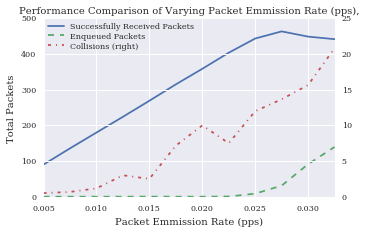

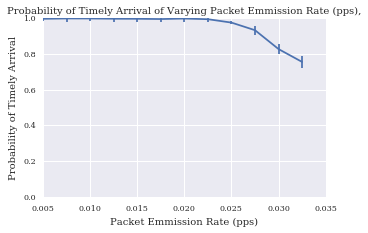

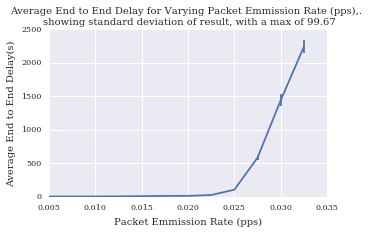

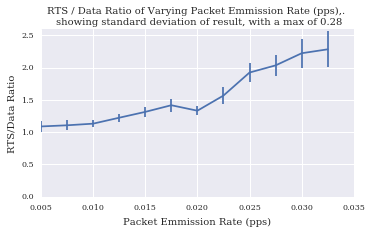

In [6]:
stats = get_emmission_stats(base_df, 100)
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({"text.usetex":False})
var="Packet Emmission Rate (pps)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
fig=cb.performance_summary_for_var(stats, var=var, rename_labels=rename_labels, hide_annotations=True, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("throughput_performance_static.pdf")
reload(cb)
fig=cb.probability_of_timely_arrival(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("prod_breakdown_static.pdf")
reload(cb)
fig=cb.average_delays_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("delay_static.pdf")
reload(cb)
fig=cb.rts_ratio_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("rts_static.pdf")

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


\begin{tabular}{
*{2}{@{\hspace{1em}}r@{\hspace{1em}}}
*{3}{@{\hspace{1em}}p{0.1\textwidth} @{\hspace{1em}}}  }
\toprule
 Separation(m) &  Delay(s) &  Probability of Arrival \\
\midrule
           100 &    103.85 &                    0.98 \\
           200 &    508.64 &                    0.93 \\
           300 &    842.53 &                    0.91 \\
           400 &   2546.43 &                    0.51 \\
           500 &   5555.37 &                    0.31 \\
           600 &   4787.46 &                    0.23 \\
           700 &   5090.62 &                    0.15 \\
           800 &   6028.37 &                    0.09 \\
\bottomrule
\end{tabular}



<module 'bounos.ChartBuilders' from '/home/bolster/src/aietes/src/bounos/ChartBuilders/__init__.pyc'>

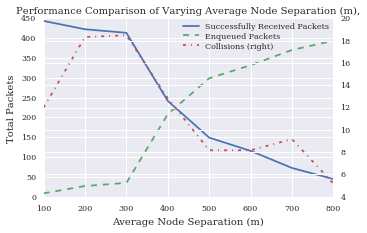

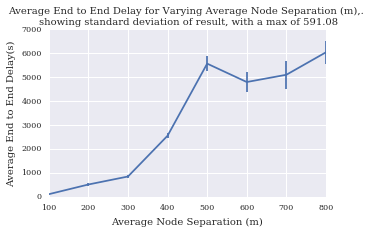

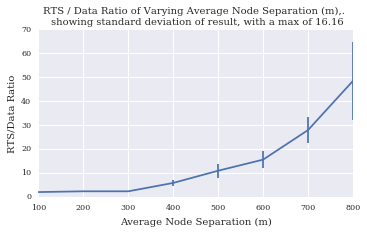

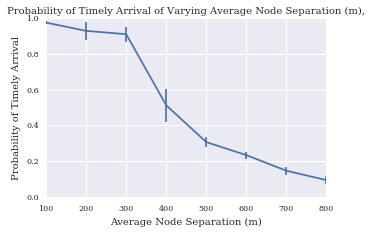

In [8]:
stats = get_separation_stats(base_df,0.025)
var = "Average Node Separation (m)"
rename_labels={"rx_counts":"Successfully Received Packets","enqueued":"Enqueued Packets", "collisions":"Collisions"}
fig=cb.performance_summary_for_var(stats, var=var, rename_labels=rename_labels, hide_annotations=True, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("throughput_performance_range.pdf")
reload(cb)

fig=cb.average_delays_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("delay_range.pdf")
reload(cb)


fig=cb.rts_ratio_across_variation(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("rts_range.pdf")
stats['error_rate'] = stats.rx_counts/stats.tx_counts
colmap={'error_rate':'Probability of Arrival','average_rx_delay':'Delay(s)'}
table = stats[['average_rx_delay','error_rate']].groupby(level='var').mean().rename(columns=colmap)
table.index.set_names('Separation(m)',inplace=True)


#ratio = (stats.rts_counts / stats.rx_counts)
#r_mean = ratio.groupby(level='var').mean()
#table['RTS/Data Ratio'] = r_mean

table.reset_index(inplace=True)
#table['Ideal Delivery Time(s)'] = table['Separation(m)']/1400.0 + 9600.0/(10000.0)

tex=table.to_latex(float_format=lambda x:"%1.2f"%x, index=False, column_format="""
*{2}{@{\\hspace{1em}}r@{\\hspace{1em}}}
*{3}{@{\\hspace{1em}}p{0.1\\textwidth} @{\\hspace{1em}}}  """)
with open('input/range_delay_table.tex','w') as f:
    f.write(tex)
print tex   

fig=cb.probability_of_timely_arrival(stats, var=var, figsize=(w,golden_mean*w))
fig.tight_layout(pad=0.1)
fig.savefig("prod_breakdown_range.pdf")
reload(cb)



# Analses Under Test

* Throughput (bits per second across the network)
* Delay (average recieved delay)
* Throughput Delay Ratio (bps per second of delay) (2D and 3D)
* Normalised Throughput Delay Product (2D and 3D)

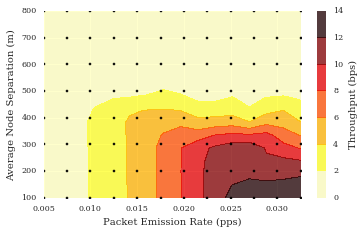

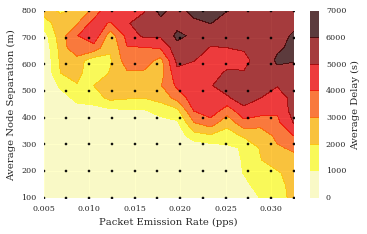

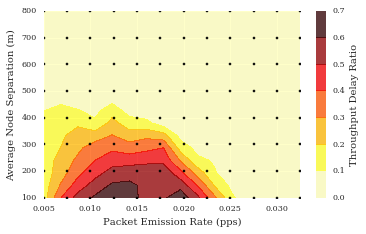

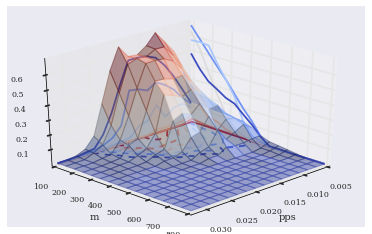

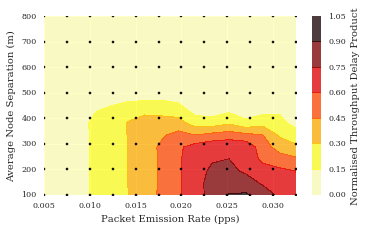

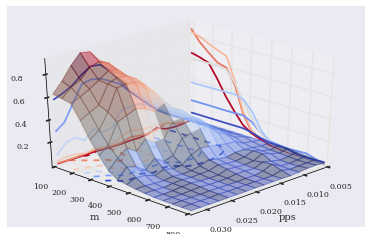

In [9]:
df=base_df.groupby(level=['rate','separation']).mean().reset_index()
import matplotlib.pylab as plt

#rc('text', usetex=False)
norm = lambda df: (df - np.nanmin(df)) / (np.nanmax(df)- np.nanmin(df))
df['average_rx_delay_norm']=1-norm(df.average_rx_delay)
df['throughput_norm']=norm(df.throughput)
df['co_norm'] = df.average_rx_delay_norm*df.throughput_norm
df = df.set_index(['rate','separation']).dropna()
df['tdivdel']=(df.throughput/df.average_rx_delay)
df.reset_index(inplace=True)

xt,yt,zt, Xt, Yt = interpolate_rate_sep(df.dropna(), "throughput")
fig=plot_contour_2d(xt,yt,zt, Xt, Yt, "Throughput (bps)" )
fig.tight_layout(pad=0.1)
fig.savefig("throughput_2d_static.pdf")

xd,yd,zd, Xd, Yd = interpolate_rate_sep(df.dropna(), "average_rx_delay")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Average Delay (s)")
fig.tight_layout(pad=0.1)
fig.savefig("delay_2d_static.pdf")


xd,yd,zd, Xd, Yd = interpolate_rate_sep(df, "tdivdel")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Throughput Delay Ratio")
fig.tight_layout(pad=0.1)
fig.savefig("2d_ratio_static.pdf")

fig=plot_contour_3d(xd,yd,zd, rot=45, labels={'x':'pps', 'y':'m','z':''})
fig.tight_layout(pad=0.1)
fig.savefig("3d_ratio_static.pdf",  transparent=True,facecolor='white')


xd,yd,zd, Xd, Yd = interpolate_rate_sep(df, "co_norm")
fig=plot_contour_2d(xd,yd,zd, Xd, Yd, "Normalised Throughput Delay Product", norm=True)
fig.tight_layout(pad=0.1)
fig.savefig("2d_normed_product_static.pdf")

fig=plot_contour_3d(xd,yd,zd, rot=45, labels={'x':'pps', 'y':'m','z':''})
fig.tight_layout(pad=0.1)
fig.savefig("3d_normed_product_static.pdf",  transparent=True,facecolor='white')


In [10]:
stats

tx_counts  rx_counts   offeredload  average_rx_delay  \
var run node                                                         
100 0   n0          453        443  45768.704000        103.384317   
        n1          457        442  46172.842667        100.270930   
        n2          461        445  46786.787556         99.511622   
        n3          452        442  45873.379556        109.896419   
        n4          451        443  45669.262222        109.766175   
        n5          452        448  46284.800000        100.291148   
200 0   n0          456        399  42024.960000        542.596950   
        n1          451        422  43821.966222        494.976177   
        n2          456        436  45968.042667        488.106120   
        n3          458        406  42521.941333        536.750977   
        n4          452        415  43096.291556        563.618395   
        n5          454        459  47832.632889        425.784745   
300 0   n0          458        404  42834.602667        903.481580   
        n1          445        424  43441.493333        825.959444   
        n2          458        390  41062.855111        861.643286   
        n3          450        420  43520.000000        753.053105   
        n4          448        427  44040.192000        884.763982   
        n5          465        418  44653.226667        826.293847   
400 0   n0          458        289  32412.558222       2544.266769   
        n1          498        197  22551.210667       2641.449102   
        n2          473        252  27984.782222       2409.582778   
        n3          458        272  30223.928889       2658.491205   
        n4          467        231  25823.232000       2403.019161   
        n5          490        210  24195.982222       2621.772817   
500 0   n0          477        136  16281.600000       5272.806952   
        n1          454        145  16219.704889       5457.406167   
        n2          497        157  20357.120000       5632.083847   
        n3          518        137  16620.202667       5629.848761   
        n4          474        148  17473.536000       6083.319919   
        n5          504        172  21217.280000       5256.783217   
600 0   n0          485        119  13905.920000       4867.031392   
        n1          507        109  13382.997333       4184.934083   
        n2          488        108  12770.417778       5074.868262   
        n3          530        113  14713.742222       5299.778496   
        n4          495        129  16332.800000       4813.360824   
        n5          476        116  13539.555556       4484.770530   
700 0   n0          488         56   7218.062222       5399.942015   
        n1          484         80   9251.498667       5063.906143   
        n2          483         77   9672.021333       5710.898424   
        n3          522         64   8314.880000       4035.171628   
        n4          534         80  10450.261333       5431.574834   
        n5          479         78   9046.926222       4902.237335   
800 0   n0          471         53   6859.434667       6374.873666   
        n1          515         55   7148.657778       5993.389952   
        n2          463         43   5267.911111       6656.746537   
        n3          496         29   3498.894222       5216.250880   
        n4          471         36   4179.968000       5947.702365   
        n5          457         51   5719.608889       5981.239377   

              energy_tot  hops  enqueued          delay  collisions  \
var run node                                                          
100 0   n0      0.442812   444         5   45799.252475          13   
        n1      0.442411   444        10   44319.751128           8   
        n2      0.441493   446        14   44282.671805           7   
        n3      0.442956   446         6   48574.217327          12   
        n4      0.442602   445         1   48626.415647          15   
        n5      

# TRUST

Reload rate and ranges for trust assessment on selected range and rate... (0.015 and 600)


In [11]:
import itertools
trust_metrics = np.asarray("ADelay,ALength,ARXP,ATXP,RXThroughput,PLR,TXThroughput".split(','))
exclude = "ATXP,ALength".split(',')
trust_combinations=[]
map(trust_combinations.extend,
    np.asarray([itertools.combinations(trust_metrics,i) 
                for i in range(3,len(trust_metrics))])
    )
trust_combinations=np.asarray(filter(lambda x: all(map(lambda m: m not in exclude,x)),trust_combinations))
#print trust_combinations
trust_metric_selections=np.asarray([map(lambda m: float(m in trust_combination),trust_metrics) for trust_combination in trust_combinations])
trust_metric_weights=map(lambda s: s/sum(s),trust_metric_selections)
#map(lambda w:trust_metrics[np.where(w>0)].tolist(),trust_metric_weights)

base_rate = 0.015
base_separation = 600

trustsd={}
for store_path in rate_and_ranges:
    with pd.get_store(store_path) as s:
        trust = s.get('trust')
        # Reset Range for separation in m
        trust.index = trust.index.set_levels([
             np.int32((np.asarray(trust.index.levels[0].astype(np.float64))*100)),  # Var
             trust.index.levels[1].astype(np.int32) # Run
            ]+(trust.index.levels[2:])
        )
        trustsd[app_rate_from_path(store_path)] = trust.copy()
df=pd.concat(trustsd.values(), keys=trustsd.keys(), names = ['rate','separation']+trust.index.names[1:])
trust_df = df.reset_index().sort(['rate','separation']).set_index(['rate','separation','run','observer','t','target'])
trust

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


ADelay  ALength        ARXP        ATXP  \
var run observer t  target                                                  
100 0   n0       1  n1         66.524352     4096  100.996132   95.793863   
                    n2         12.096863     4096  101.413542   95.793863   
                    n3         48.237039     4096  100.383263   95.793863   
                    n4         95.012744     4096  102.362309   95.793863   
                    n5         62.419774     4096  101.170308   95.793863   
                 2  n1         76.305243     4096  100.792288   95.793863   
                    n2        204.658155     4096  100.323911   95.793863   
                    n3         21.174439     4096  101.078906   95.793863   
                    n4        150.863876     4096  100.734755   95.793863   
                    n5        209.310784     4096  100.960997   95.793863   
                 3  n1        100.415453     4096  102.880445   95.793863   
                    n2        414.077671     4096   99.818865   95.793863   
                    n3        340.133980     4096  106.338129   95.793863   
                    n4         29.019738     4096  102.658104   95.793863   
                    n5        419.252522     4096   99.885797   95.793863   
                 4  n1         93.978297     4096  101.167884   95.793863   
                    n2        494.494590     4096  105.435111   95.793863   
                    n3        589.778144     4096  103.663416   95.793863   
                    n4        448.221136     4096  101.242406   95.793863   
                    n5        377.248191     4096   99.979545   95.793863   
                 5  n1         79.998070     4096  102.205755   95.793863   
                    n2        785.643075     4096  102.322483   95.793863   
                    n3        725.837673     4096   99.431711   95.793863   
                    n4        488.199823     4096  101.669529   95.793863   
                    n5        800.165701     4096  100.538357   95.793863   
                 6  n1        444.595114     4096  101.914607   95.793863   
                    n2       1124.858819     4096   99.389002   95.793863   
                    n3       1063.171733     4096  102.525986   95.793863   
                    n4        528.645987     4096  101.372674   95.793863   
                    n5       1177.046816     4096   99.867060   95.793863   
...                                  ...      ...         ...         ...   
800 0   n5       24 n0               NaN      NaN         NaN         NaN   
                    n1               NaN      NaN         NaN         NaN   
                    n2               NaN      NaN         NaN         NaN   
                    n3               NaN      NaN         NaN         NaN   
                    n4      11554.301437     4096   97.841042   95.793863   
                 25 n0               NaN      NaN         NaN         NaN   
                    n1               NaN      NaN         NaN         NaN   
                    n2               NaN      NaN         NaN         NaN   
                    n3               NaN      NaN         NaN         NaN   
                    n4      11554.301437     4096   97.841042   95.793863   
                 26 n0               NaN      NaN         NaN         NaN   
                    n1               NaN      NaN         NaN         NaN   
                    n2               NaN      NaN         NaN         NaN   
                    n3               NaN      NaN         NaN         NaN   
                    n4      11554.301437     4096   97.841042   95.793863   
                 27 n0               NaN      NaN         NaN         NaN   
                    n1      13982.519813     4096   87.348735   99.734862   
                    n2      13021.268769     4096   95.753911   95.793863   
                    n3               NaN      NaN         NaN         NaN   
                    n4      11

In [12]:
base_df.xs(0.015,level="rate")

tx_counts  rx_counts   offeredload  average_rx_delay  \
separation run node                                                         
100        0   n0          266        273  16645.688889          8.274316   
               n1          268        271  16526.904889          7.445532   
               n2          270        269  16527.360000          6.657119   
               n3          275        265  16583.111111          9.131134   
               n4          270        269  16527.360000          8.006899   
               n5          269        268  16466.147556          7.528564   
200        0   n0          274        268  16709.859556          6.880229   
               n1          270        271  16711.680000          8.166409   
               n2          273        270  16773.120000          9.709031   
               n3          270        272  16773.120000          8.100070   
               n4          268        274  16709.859556          6.992456   
               n5          272        270  16711.680000          8.999853   
300        0   n0          268        271  16831.829333         16.664073   
               n1          277        272  17144.945778         13.915913   
               n2          275        266  17271.466667         16.450986   
               n3          274        270  17208.661333         17.075648   
               n4          275        268  17083.733333         14.068488   
               n5          277        271  17144.945778         13.124160   
400        0   n0          282        270  17903.616000         76.004000   
               n1          278        271  17902.705778         73.002682   
               n2          285        270  18094.080000         68.124529   
               n3          272        273  17021.155556         71.234195   
               n4          276        270  18087.936000         77.566793   
               n5          292        265  18604.942222         71.622990   
500        0   n0          303        105   7998.122667       2486.832237   
               n1          312        101   7951.701333       3080.166905   
               n2          310        108   8112.355556       2643.954521   
               n3          297        101   7434.240000       2404.074698   
               n4          299        105   8232.732444       1920.314045   
               n5          301        115   8561.777778       2711.793403   
600        0   n0          320         81   6553.600000       5336.857269   
               n1          284         79   6010.197333       3707.341066   
               n2          318        123  10492.586667       4116.165974   
               n3          336         97   8639.829333       3959.337396   
               n4          346        116  10786.588444       4772.769233   
               n5          327         78   7441.066667       4387.203596   
700        0   n0          297         45   3852.288000       4541.399539   
               n1          308         50   3854.791111       5317.042428   
               n2          309         49   4078.250667       5482.564452   
               n3          342         69   6070.272000       5047.329636   
               n4          310         59   4796.871111       4882.351662   
               n5          295         63   4900.408889       5713.494806   
800        0   n0          329         52   4192.483556       3714.524111   
               n1          320         52   4004.977778       3486.786382   
               n2          297         54   4122.624000       4635.996052   
               n3          321         54   4309.674667       2896.153610   
               n4          314         50   4287.146667       4224.993223   
               n5          275         50   3566.933333       4228.388560   

                     energy_tot  hops  enqueued          delay  collisions  \
separation run node                                                          
100        0  

In [13]:
pylab.rcParams['figure.figsize'] = 16, 12  

_=(stats.unstack(level='node').throughput/3600).groupby(level='var').boxplot()

NameError: name 'pylab' is not defined

In [14]:
from __future__ import division 
choices = zip(range(5),np.random.random_integers(1000,10000,5))
names, distances = zip(*choices)
inv_distances = 1.0/np.array(distances)
norm_distances = inv_distances/sum(inv_distances)
norm_distances, choices

(array([ 0.142,  0.169,  0.183,  0.436,  0.07 ]),
 [(0, 3281), (1, 2770), (2, 2559), (3, 1072), (4, 6659)])

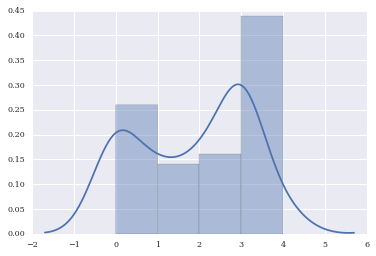

In [15]:
sns.distplot([np.random.choice(names, p=norm_distances) for _ in range(100)])

In [ ]:
for v,g in rx.reset_index().set_index('received').groupby(['var','run','node']):
    g.index=pd.to_datetime(g.index)
    #print g.count(axis=0)

In [ ]:
stats